# Knowledge Graphs in Decision Making

> **"Knowledge graphs transform unstructured data into structured knowledge for intelligent decision making."**

## Learning Objectives
- Understand knowledge graphs and their role in decision making
- Learn to construct and visualize knowledge graphs from real data
- Master graph-based machine learning techniques
- Implement decision making models using knowledge graphs
- Apply knowledge graphs to real-world business problems
- Build recommendation systems using graph structures


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict, Counter
import json
import warnings
warnings.filterwarnings('ignore')

# Graph ML libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_networkx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NetworkX version: {nx.__version__}")


Libraries imported successfully!
PyTorch version: 2.1.1+cpu
NetworkX version: 3.2.1


## 1. Understanding Knowledge Graphs

### What are Knowledge Graphs?
Knowledge graphs are structured representations of information that capture entities, their properties, and relationships between them. They enable machines to understand context and make intelligent decisions.

### Key Components:
- **Entities**: Real-world objects (people, products, concepts)
- **Relationships**: Connections between entities
- **Properties**: Attributes of entities
- **Triples**: (Subject, Predicate, Object) format

### Real-World Applications:
- **E-commerce**: Product recommendations, fraud detection
- **Healthcare**: Drug discovery, patient diagnosis
- **Finance**: Risk assessment, fraud detection
- **Social Networks**: Friend recommendations, content filtering


In [3]:
# Create a real-world e-commerce knowledge graph
class ECommerceKnowledgeGraph:
    """E-commerce knowledge graph for product recommendations and decision making."""
    
    def __init__(self):
        self.entities = {}
        self.relationships = []
        self.entity_types = ['Product', 'Customer', 'Category', 'Brand', 'Review']
        self.relationship_types = ['purchased', 'belongs_to', 'manufactured_by', 'reviewed_by', 'similar_to', 'recommended_for']
        
    def add_entity(self, entity_id, entity_type, properties=None):
        """Add an entity to the knowledge graph."""
        if properties is None:
            properties = {}
        self.entities[entity_id] = {
            'type': entity_type,
            'properties': properties
        }
    
    def add_relationship(self, subject, predicate, object_entity, weight=1.0):
        """Add a relationship between entities."""
        self.relationships.append({
            'subject': subject,
            'predicate': predicate,
            'object': object_entity,
            'weight': weight
        })
    
    def get_entity_neighbors(self, entity_id, relationship_type=None):
        """Get neighbors of an entity."""
        neighbors = []
        for rel in self.relationships:
            if rel['subject'] == entity_id and (relationship_type is None or rel['predicate'] == relationship_type):
                neighbors.append((rel['object'], rel['predicate'], rel['weight']))
            elif rel['object'] == entity_id and (relationship_type is None or rel['predicate'] == relationship_type):
                neighbors.append((rel['subject'], rel['predicate'], rel['weight']))
        return neighbors
    
    def to_networkx(self):
        """Convert to NetworkX graph for visualization."""
        G = nx.Graph()
        
        # Add nodes
        for entity_id, entity_data in self.entities.items():
            G.add_node(entity_id, **entity_data)
        
        # Add edges
        for rel in self.relationships:
            G.add_edge(rel['subject'], rel['object'], 
                      predicate=rel['predicate'], weight=rel['weight'])
        
        return G

# Create sample e-commerce data
def create_sample_ecommerce_data():
    """Create sample e-commerce knowledge graph data."""
    kg = ECommerceKnowledgeGraph()
    
    # Products
    products = [
        ('P001', 'iPhone 15 Pro', 'Electronics', 'Apple', 999.99, 4.8),
        ('P002', 'Samsung Galaxy S24', 'Electronics', 'Samsung', 899.99, 4.6),
        ('P003', 'MacBook Pro M3', 'Electronics', 'Apple', 1999.99, 4.9),
        ('P004', 'Nike Air Max', 'Fashion', 'Nike', 129.99, 4.4),
        ('P005', 'Adidas Ultraboost', 'Fashion', 'Adidas', 149.99, 4.5),
        ('P006', 'Coffee Maker', 'Home', 'Breville', 299.99, 4.3),
        ('P007', 'Blender', 'Home', 'Vitamix', 399.99, 4.7),
        ('P008', 'Running Shoes', 'Fashion', 'Nike', 89.99, 4.2),
        ('P009', 'Laptop Stand', 'Electronics', 'Logitech', 49.99, 4.1),
        ('P010', 'Wireless Mouse', 'Electronics', 'Logitech', 29.99, 4.0)
    ]
    
    # Customers
    customers = [
        ('C001', 'Alice Johnson', 'Premium', 'Tech Enthusiast'),
        ('C002', 'Bob Smith', 'Standard', 'Fashion Lover'),
        ('C003', 'Carol Davis', 'Premium', 'Home Decorator'),
        ('C004', 'David Wilson', 'Standard', 'Fitness Enthusiast'),
        ('C005', 'Eva Brown', 'Premium', 'Gadget Collector')
    ]
    
    # Add entities
    for product_id, name, category, brand, price, rating in products:
        kg.add_entity(product_id, 'Product', {
            'name': name, 'category': category, 'brand': brand, 
            'price': price, 'rating': rating
        })
        kg.add_entity(category, 'Category', {'name': category})
        kg.add_entity(brand, 'Brand', {'name': brand})
    
    for customer_id, name, tier, profile in customers:
        kg.add_entity(customer_id, 'Customer', {
            'name': name, 'tier': tier, 'profile': profile
        })
    
    # Add relationships
    for product_id, name, category, brand, price, rating in products:
        kg.add_relationship(product_id, 'belongs_to', category, 1.0)
        kg.add_relationship(product_id, 'manufactured_by', brand, 1.0)
    
    # Purchase relationships (simulated based on customer profiles)
    purchase_patterns = [
        ('C001', 'P001', 0.9),  # Alice - iPhone
        ('C001', 'P003', 0.8),  # Alice - MacBook
        ('C001', 'P009', 0.7),  # Alice - Laptop Stand
        ('C001', 'P010', 0.6),  # Alice - Mouse
        ('C002', 'P004', 0.9),  # Bob - Nike Air Max
        ('C002', 'P005', 0.8),  # Bob - Adidas Ultraboost
        ('C002', 'P008', 0.7),  # Bob - Running Shoes
        ('C003', 'P006', 0.9),  # Carol - Coffee Maker
        ('C003', 'P007', 0.8),  # Carol - Blender
        ('C004', 'P004', 0.8),  # David - Nike Air Max
        ('C004', 'P005', 0.9),  # David - Adidas Ultraboost
        ('C004', 'P008', 0.9),  # David - Running Shoes
        ('C005', 'P001', 0.8),  # Eva - iPhone
        ('C005', 'P002', 0.7),  # Eva - Samsung Galaxy
        ('C005', 'P003', 0.9),  # Eva - MacBook
    ]
    
    for customer_id, product_id, weight in purchase_patterns:
        kg.add_relationship(customer_id, 'purchased', product_id, weight)
    
    # Similarity relationships between products
    similarities = [
        ('P001', 'P002', 0.8),  # iPhone - Samsung Galaxy
        ('P004', 'P005', 0.9),  # Nike Air Max - Adidas Ultraboost
        ('P004', 'P008', 0.7),  # Nike Air Max - Running Shoes
        ('P006', 'P007', 0.6),  # Coffee Maker - Blender
        ('P009', 'P010', 0.8),  # Laptop Stand - Mouse
    ]
    
    for prod1, prod2, weight in similarities:
        kg.add_relationship(prod1, 'similar_to', prod2, weight)
        kg.add_relationship(prod2, 'similar_to', prod1, weight)
    
    return kg

# Create the knowledge graph
kg = create_sample_ecommerce_data()
print("E-commerce Knowledge Graph created successfully!")
print(f"Number of entities: {len(kg.entities)}")
print(f"Number of relationships: {len(kg.relationships)}")

# Display entity types
entity_counts = Counter([entity['type'] for entity in kg.entities.values()])
print(f"\nEntity distribution: {dict(entity_counts)}")

# Display relationship types
rel_counts = Counter([rel['predicate'] for rel in kg.relationships])
print(f"Relationship distribution: {dict(rel_counts)}")


E-commerce Knowledge Graph created successfully!
Number of entities: 25
Number of relationships: 45

Entity distribution: {'Product': 10, 'Category': 3, 'Brand': 7, 'Customer': 5}
Relationship distribution: {'belongs_to': 10, 'manufactured_by': 10, 'purchased': 15, 'similar_to': 10}


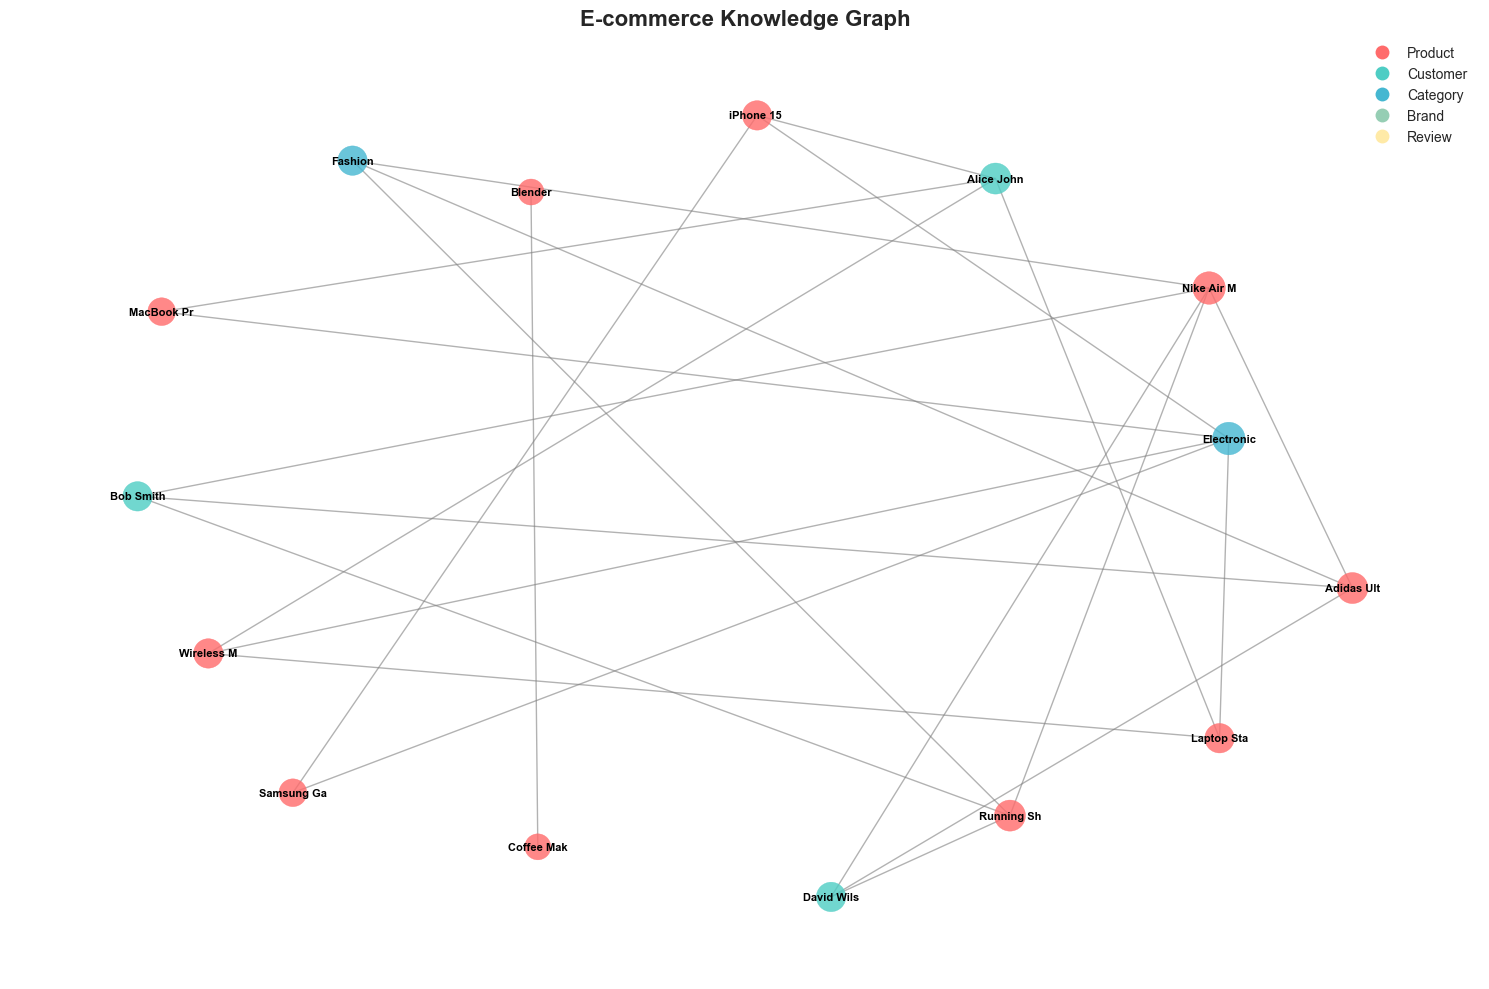

Graph Statistics:
Nodes: 15
Edges: 23
Average degree: 3.07
Connected components: 3


In [4]:
# Visualize the knowledge graph
def visualize_knowledge_graph(kg, max_nodes=20):
    """Visualize the knowledge graph with different entity types."""
    G = kg.to_networkx()
    
    # Create subgraph with limited nodes for better visualization
    if len(G.nodes()) > max_nodes:
        # Get most connected nodes
        node_degrees = dict(G.degree())
        top_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        G = G.subgraph([node for node, _ in top_nodes])
    
    # Create layout
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Color nodes by entity type
    node_colors = []
    node_sizes = []
    node_labels = {}
    
    color_map = {
        'Product': '#FF6B6B',
        'Customer': '#4ECDC4', 
        'Category': '#45B7D1',
        'Brand': '#96CEB4',
        'Review': '#FFEAA7'
    }
    
    for node in G.nodes():
        entity_type = G.nodes[node].get('type', 'Unknown')
        node_colors.append(color_map.get(entity_type, '#DDA0DD'))
        
        # Size based on degree
        degree = G.degree(node)
        node_sizes.append(300 + degree * 50)
        
        # Label with entity name
        if 'name' in G.nodes[node].get('properties', {}):
            node_labels[node] = G.nodes[node]['properties']['name'][:10]
        else:
            node_labels[node] = node
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, 
                          alpha=0.6,
                          width=1,
                          edge_color='gray')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, 
                           labels=node_labels,
                           font_size=8,
                           font_weight='bold')
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color, markersize=10, label=entity_type)
                      for entity_type, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title("E-commerce Knowledge Graph", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print graph statistics
    print(f"Graph Statistics:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Connected components: {nx.number_connected_components(G)}")

# Visualize the knowledge graph
visualize_knowledge_graph(kg, max_nodes=15)


## 2. Decision Making with Knowledge Graphs

### Graph-Based Recommendation System
Knowledge graphs enable sophisticated recommendation systems by:
- **Collaborative Filtering**: Finding similar users based on purchase patterns
- **Content-Based Filtering**: Recommending similar products
- **Hybrid Approaches**: Combining multiple signals for better recommendations

### Key Decision Making Applications:
1. **Product Recommendations**: Suggest products based on user behavior and product relationships
2. **Fraud Detection**: Identify suspicious patterns in transaction networks
3. **Risk Assessment**: Evaluate customer risk based on network connections
4. **Market Analysis**: Understand product relationships and market trends


In [5]:
# Graph-Based Recommendation System
class GraphRecommendationSystem:
    """Recommendation system based on knowledge graph analysis."""
    
    def __init__(self, knowledge_graph):
        self.kg = knowledge_graph
        self.G = knowledge_graph.to_networkx()
        
    def collaborative_filtering(self, customer_id, n_recommendations=5):
        """Find products based on similar customers."""
        # Get products purchased by the customer
        customer_products = set()
        for rel in self.kg.relationships:
            if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
                customer_products.add(rel['object'])
        
        if not customer_products:
            return []
        
        # Find similar customers (those who bought similar products)
        similar_customers = {}
        for rel in self.kg.relationships:
            if (rel['predicate'] == 'purchased' and 
                rel['object'] in customer_products and 
                rel['subject'] != customer_id):
                
                if rel['subject'] not in similar_customers:
                    similar_customers[rel['subject']] = 0
                similar_customers[rel['subject']] += rel['weight']
        
        # Get products from similar customers
        recommendations = {}
        for similar_customer, similarity_score in similar_customers.items():
            for rel in self.kg.relationships:
                if (rel['subject'] == similar_customer and 
                    rel['predicate'] == 'purchased' and 
                    rel['object'] not in customer_products):
                    
                    product = rel['object']
                    if product not in recommendations:
                        recommendations[product] = 0
                    recommendations[product] += similarity_score * rel['weight']
        
        # Sort by score and return top recommendations
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def content_based_filtering(self, customer_id, n_recommendations=5):
        """Find products based on product similarity."""
        # Get products purchased by the customer
        customer_products = set()
        for rel in self.kg.relationships:
            if rel['subject'] == customer_id and rel['predicate'] == 'purchased':
                customer_products.add(rel['object'])
        
        if not customer_products:
            return []
        
        # Find similar products
        recommendations = {}
        for rel in self.kg.relationships:
            if (rel['predicate'] == 'similar_to' and 
                rel['subject'] in customer_products and 
                rel['object'] not in customer_products):
                
                product = rel['object']
                if product not in recommendations:
                    recommendations[product] = 0
                recommendations[product] += rel['weight']
        
        # Sort by score and return top recommendations
        sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def hybrid_recommendation(self, customer_id, n_recommendations=5, alpha=0.6):
        """Combine collaborative and content-based filtering."""
        collab_recs = dict(self.collaborative_filtering(customer_id, n_recommendations * 2))
        content_recs = dict(self.content_based_filtering(customer_id, n_recommendations * 2))
        
        # Combine scores
        hybrid_recs = {}
        all_products = set(collab_recs.keys()) | set(content_recs.keys())
        
        for product in all_products:
            collab_score = collab_recs.get(product, 0)
            content_score = content_recs.get(product, 0)
            
            # Normalize scores
            if collab_score > 0 and content_score > 0:
                hybrid_score = alpha * collab_score + (1 - alpha) * content_score
            else:
                hybrid_score = max(collab_score, content_score)
            
            hybrid_recs[product] = hybrid_score
        
        # Sort and return top recommendations
        sorted_recs = sorted(hybrid_recs.items(), key=lambda x: x[1], reverse=True)
        return sorted_recs[:n_recommendations]
    
    def get_product_info(self, product_id):
        """Get detailed information about a product."""
        if product_id in self.kg.entities:
            return self.kg.entities[product_id]['properties']
        return None

# Initialize recommendation system
rec_system = GraphRecommendationSystem(kg)

# Test recommendations for different customers
customers = ['C001', 'C002', 'C003', 'C004', 'C005']

print("=== Graph-Based Recommendation System ===\n")

for customer_id in customers:
    customer_name = kg.entities[customer_id]['properties']['name']
    customer_profile = kg.entities[customer_id]['properties']['profile']
    
    print(f"Customer: {customer_name} ({customer_profile})")
    print("-" * 50)
    
    # Get different types of recommendations
    collab_recs = rec_system.collaborative_filtering(customer_id, 3)
    content_recs = rec_system.content_based_filtering(customer_id, 3)
    hybrid_recs = rec_system.hybrid_recommendation(customer_id, 3)
    
    print("Collaborative Filtering:")
    for product_id, score in collab_recs:
        product_info = rec_system.get_product_info(product_id)
        if product_info:
            print(f"  - {product_info['name']} (Score: {score:.3f})")
    
    print("\nContent-Based Filtering:")
    for product_id, score in content_recs:
        product_info = rec_system.get_product_info(product_id)
        if product_info:
            print(f"  - {product_info['name']} (Score: {score:.3f})")
    
    print("\nHybrid Recommendation:")
    for product_id, score in hybrid_recs:
        product_info = rec_system.get_product_info(product_id)
        if product_info:
            print(f"  - {product_info['name']} (Score: {score:.3f})")
    
    print("\n" + "="*60 + "\n")


=== Graph-Based Recommendation System ===

Customer: Alice Johnson (Tech Enthusiast)
--------------------------------------------------
Collaborative Filtering:
  - Samsung Galaxy S24 (Score: 1.190)

Content-Based Filtering:
  - Samsung Galaxy S24 (Score: 0.800)

Hybrid Recommendation:
  - Samsung Galaxy S24 (Score: 1.034)


Customer: Bob Smith (Fashion Lover)
--------------------------------------------------
Collaborative Filtering:

Content-Based Filtering:

Hybrid Recommendation:


Customer: Carol Davis (Home Decorator)
--------------------------------------------------
Collaborative Filtering:

Content-Based Filtering:

Hybrid Recommendation:


Customer: David Wilson (Fitness Enthusiast)
--------------------------------------------------
Collaborative Filtering:

Content-Based Filtering:

Hybrid Recommendation:


Customer: Eva Brown (Gadget Collector)
--------------------------------------------------
Collaborative Filtering:
  - Laptop Stand (Score: 1.190)
  - Wireless Mouse (Sco